In [17]:
import numpy as np
import scipy as sp

In [18]:
from matplotlib import pyplot as plt
import skimage
from skimage import (morphology, segmentation, exposure, feature, filters,
                     measure, transform, util, io, color)

In [19]:
from toolz.curried import *

In [20]:
from spotz import imgz, gridder2, segmenter2, spotzplot

In [21]:
from importlib import reload

In [22]:
reload(imgz)
reload(gridder2)
reload(spotzplot)
reload(segmenter2)

<module 'segmenter2' from '/Users/pmagwene/gits/spotz/segmenter2.py'>

In [23]:
%matplotlib inline

# User settings

In [239]:
# change name of file
PLATE_IMG = "test2-384.tif"
OUTPUT_FILE = "test_output.csv"

# change number of rows and cols as appropriate
NROWS = 16
NCOLS = 24

# change if you'd like larger or smaller figs
FIG_SIZE = (10,8)

# Original image

In [240]:
img = imgz.read_image(PLATE_IMG)

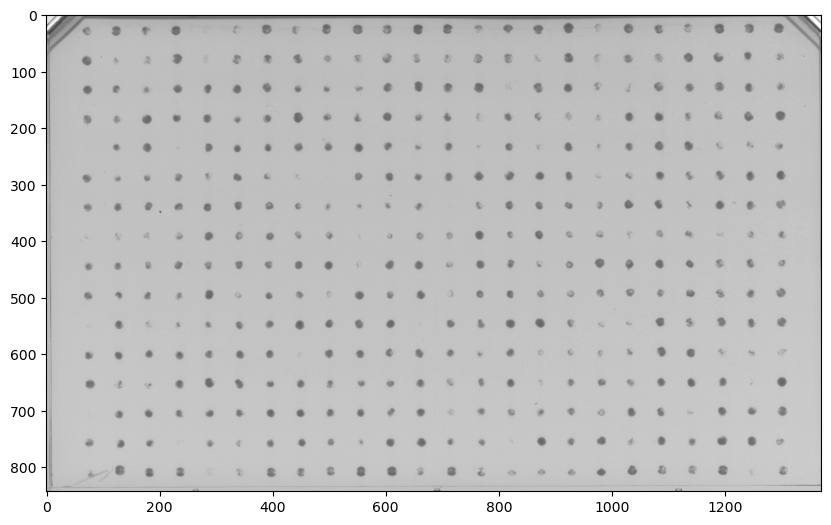

In [241]:
fig = plt.figure(figsize = FIG_SIZE)
imgz.imshowg(img)

# Invert image

In [219]:
iimg = imgz.invert(img)

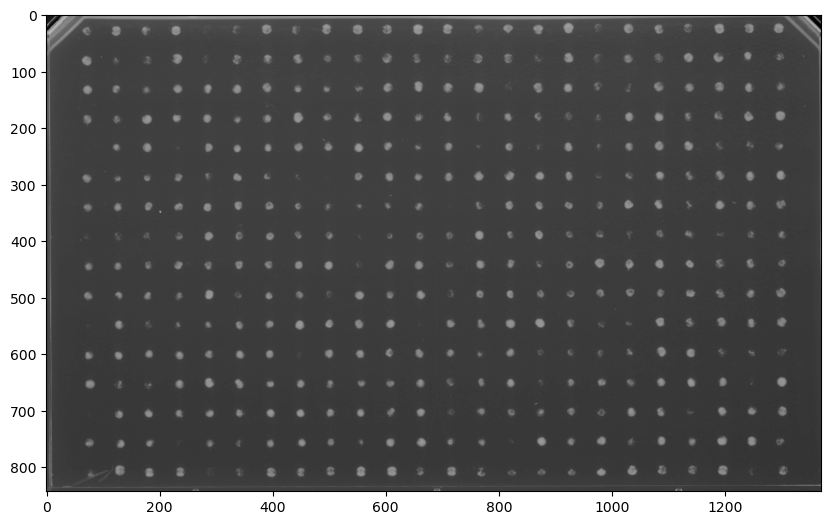

In [220]:
fig = plt.figure(figsize = FIG_SIZE)
imgz.imshowg(iimg)
pass

# Gridding

## Thresholding and binary opening

In [221]:
# initial thresholding and rotation correction
rbimg = pipe(iimg, 
             imgz.threshold_otsu,
             imgz.disk_opening(3), 
             imgz.clear_border, 
             gridder2.fix_rotation)


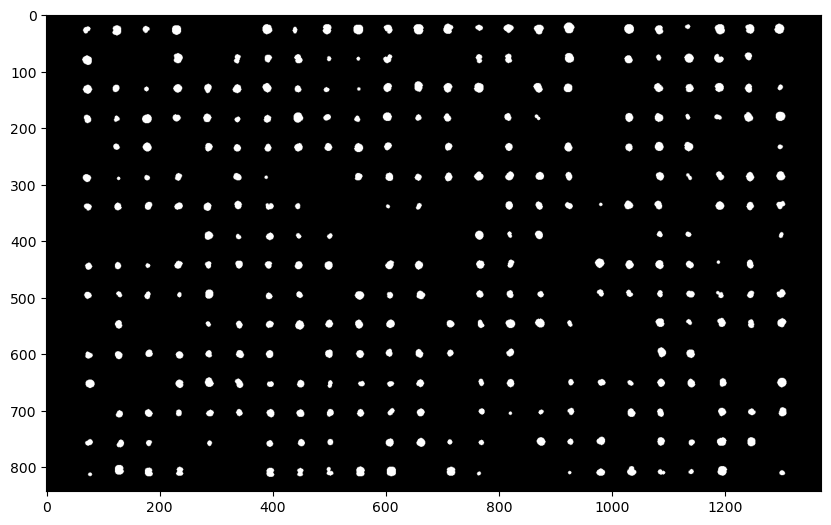

In [222]:
fig = plt.figure(figsize = FIG_SIZE)
imgz.imshowg(rbimg)
pass

## Estimate grid coordinates and draw grid

In [223]:
g = gridder2.find_grid(NROWS, NCOLS, rbimg)

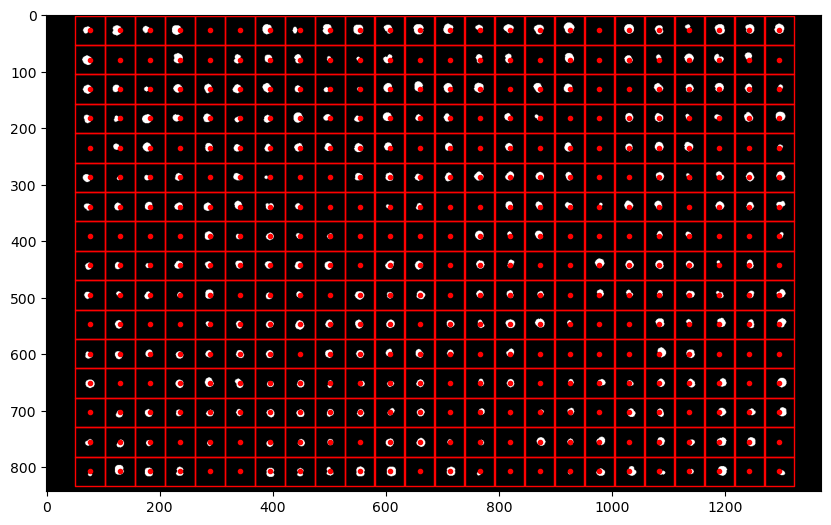

In [224]:
fig = plt.figure(figsize = FIG_SIZE)
imgz.imshowg(rbimg)
ax = plt.gca()
ax.plot(g.centers[:,1], g.centers[:,0], 'r.')
spotzplot.draw_bboxes(g.bboxes, ax)
pass

# Segmentation

## Rethreshold based on grid

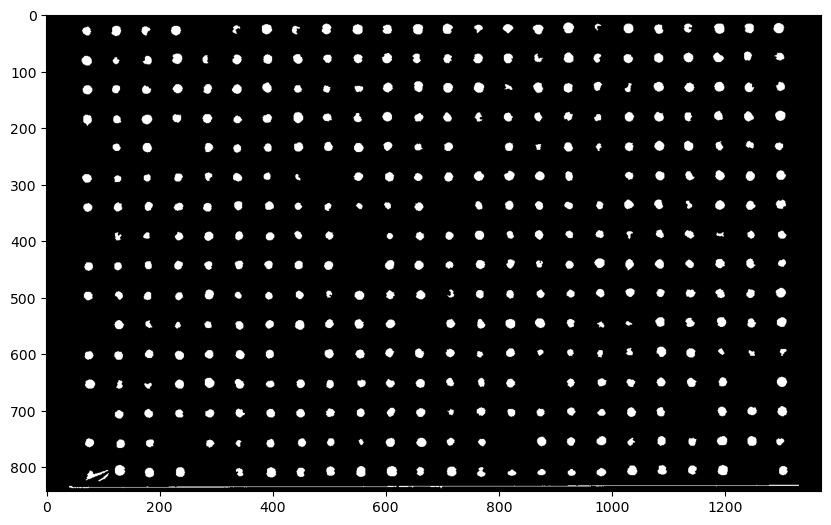

In [225]:
timg = pipe(iimg,
            segmenter2.threshold_bboxes(g.bboxes, min_local_threshold=0.8),
            imgz.remove_small_objects(50),
            imgz.remove_small_holes(25),
            imgz.disk_closing(1),
            imgz.clear_border)

fig = plt.figure(figsize = FIG_SIZE)
imgz.imshowg(timg)
pass

## Segmentation by watershed

### Filter objects by grid

In [226]:
filtered_img, filtered_regions = segmenter2.assign_objects_to_grid(g.centers, 
                                                                   timg, 
                                                                   maxdist = 30) 
filtered_bboxes = [r.bbox if r else None for r in filtered_regions]



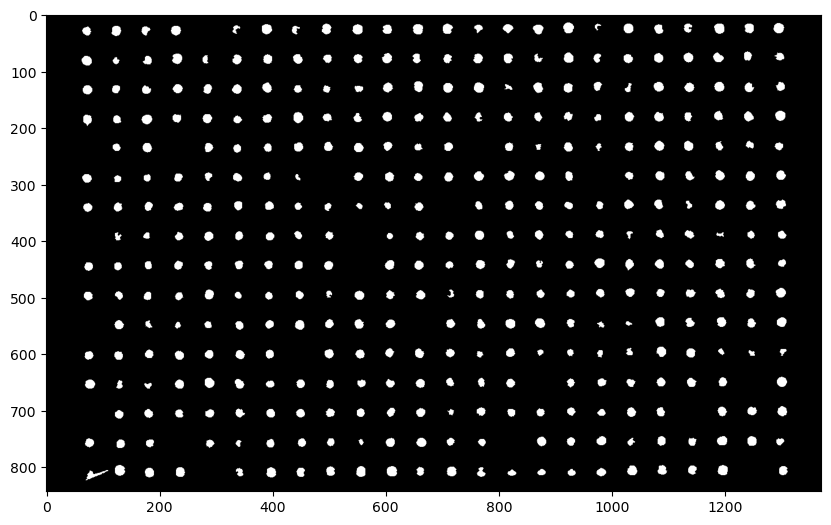

In [227]:
fig = plt.figure(figsize = FIG_SIZE)
imgz.imshowg(filtered_img > 0)
pass

In [228]:
wshed = segmenter2.watershed_segment_bboxes(g.centers, 
                                             filtered_bboxes, 
                                             iimg, timg, 
                                             seed_width = 5)

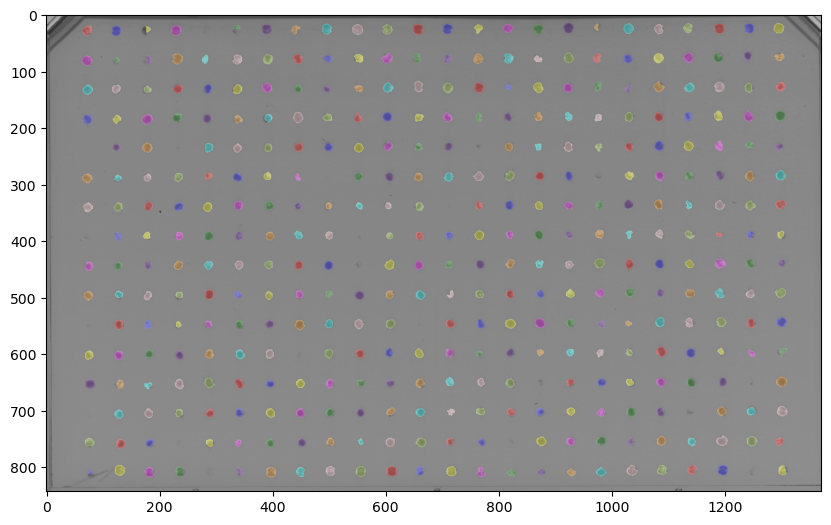

In [229]:
fig = plt.figure(figsize = FIG_SIZE)
ax = plt.gca()
ax.imshow(color.label2rgb(wshed, img, bg_label = 0))
pass

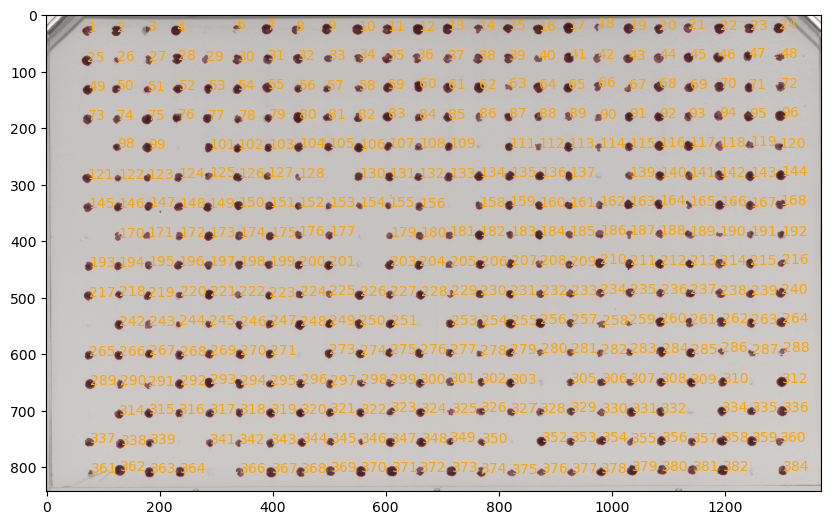

In [230]:
fig, ax = spotzplot.draw_image_and_labels(img, wshed,
                                          mask_cmap = "Reds", alpha = 0.35,
                                         fontsize = 10, textcolor = "orange")
fig.set_size_inches(FIG_SIZE)

In [231]:
import spotstats

In [232]:
regions = measure.regionprops(wshed, intensity_image = filtered_img)

In [233]:
colonydf = spotstats.colony_stats(regions, 16, 24)
colonydf

,label,row,col,centroid_r,centroid_c,area,perimeter,major_axis_length,minor_axis_length,eccentricity,equiv_diameter,mean_intensity,solidity,convex_area,bbox_minr,bbox_minc,bbox_maxr,bbox_maxc
0,1,1.0,1.0,28.763393,72.540179,224.0,62.284271,19.570371,15.269266,0.625501,16.888033,0.763393,0.937238,239.0,21,64,39,81
1,2,1.041667,1.0,29.262548,124.293436,259.0,59.112698,19.340398,17.310956,0.445931,18.159544,1.830116,0.95572,271.0,21,116,39,134
2,3,1.083333,1.0,26.652174,179.971014,69.0,30.970563,10.828775,8.77282,0.586237,9.373021,2.391304,0.932432,74.0,21,177,33,186
3,4,1.125,1.0,28.564202,229.766537,257.0,57.698485,18.732823,17.491836,0.357917,18.089294,3.673152,0.95539,269.0,20,221,38,240
4,5,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,380,16.791667,1.0,805.455752,1089.221239,226.0,55.455844,17.768423,16.517077,0.368634,16.963258,346.371681,0.941667,240.0,797,1081,814,1098
380,381,16.833333,1.0,805.112676,1142.629108,213.0,54.284271,17.754808,15.54869,0.482773,16.468152,334.492958,0.938326,227.0,797,1135,814,1152
381,382,16.875,1.0,805.758865,1196.776596,282.0,60.870058,19.742668,18.250861,0.381334,18.948708,350.843972,0.955932,295.0,797,1187,815,1207
382,383,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [101]:
colonydf.to_csv(OUTPUT_FILE, index=False)
print("file saved as", OUTPUT_FILE)

file saved as test_output.csv
